# Project Title: Passengers Count (Hourly Predictions)

Project Goal and Description: The aim of this project is to predict new passengers overtime using TLC Trip Record Data
Source Link: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf https://www.nyc.gov/assets/tlc/downloads/pdf/trip_record_user_guide.pdf

# Import Modules

In [1]:
import os
import sys
import warnings
from credentials import *
sys.path.append(sys_path_ds)
import IPython
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import IPython.display
from PIL import Image
import tensorflow as tf
from Queries.ml import *
import matplotlib as mpl
import matplotlib.pyplot as plt
from urllib.request import urlopen
from sqlalchemy import text, create_engine

# Options and Settings

In [2]:
warnings.simplefilter('ignore')
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Load Image

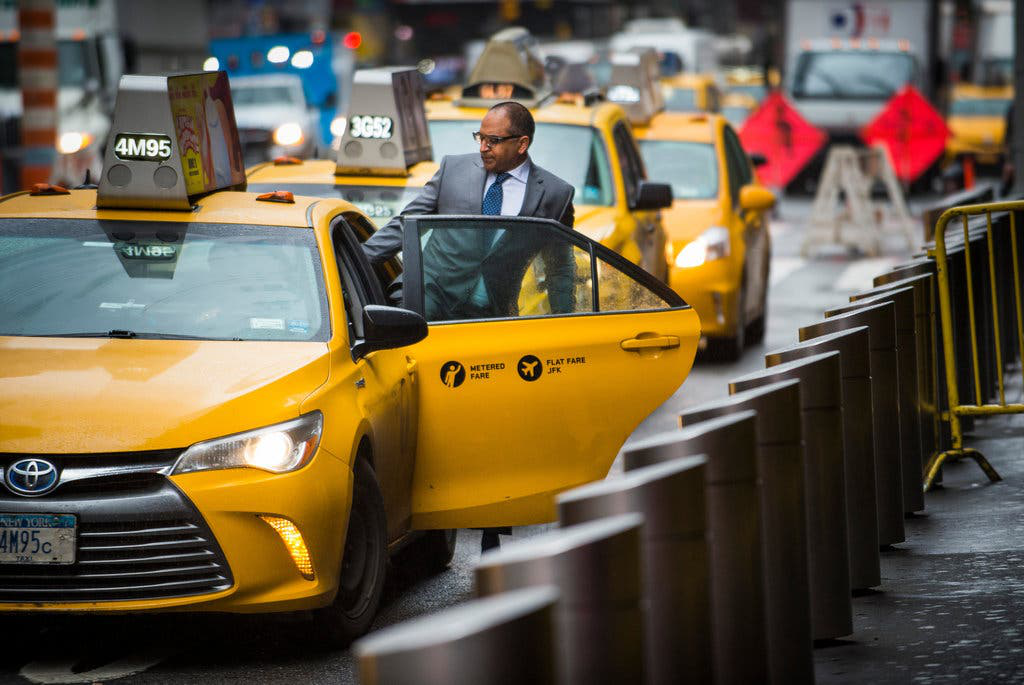

In [3]:
image_url = 'https://static01.nyt.com/images/2017/06/07/nyregion/07TAXI1/07TAXI1-jumbo.jpg?quality=75&auto=webp'
Image.open(urlopen(image_url))

# Helper Functions

In [4]:
def get_data(query: str)->pd.DataFrame:
    '''
    Fetches data from Postgresql database and returns a pandas dataframe

    '''
    engine = create_engine(f'{driver_postgres}://{user_postgres}:{password_postgres}@{hostname_postgres}/{pg_db_yt}')
    
    with engine.connect() as conn:
        df = pd.read_sql(sql=text(query), con=conn)
        conn.close()
    return df



def plot_line(data: pd.DataFrame, rule: str, rot: int = 45, xlabel: str = None, ylabel: str = None, title: str = None):
    '''
    Plots a line chart of passenger count overtime

    data: pd.DataFrame
        pandas dataframe
    
    rule: ruleDateOffset, Timedelta or str
        https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html
    
    '''
    return data.set_index('tpep_pickup_datetime').resample(rule).count().plot(xlabel=xlabel, ylabel=ylabel, title=title, rot=rot)



def plot_violin(data: pd.DataFrame, t: str = None, xlabel: str = None, ylabel: str = None, title: str = None):
    '''
    Draw a combination of boxplot and kernel density estimate.

    data: DataFrame, array, or list of arrays, optional
        Dataset for plotting.

    t: str
       Main plot title
    
    '''
    fig, ax = plt.subplots()
    fig.suptitle(t=t)

    sns.violinplot(data=data)
    
    ax.set(xlabel=xlabel, ylabel=ylabel, title=title)

    return plot_violin

# Extract Data

In [5]:
df = get_data(query1)
df = df.set_index('tpep_pickup_datetime').resample('H').count().reset_index()   # sub-sample the data to one-hour intervals

In [6]:
df.head()

,tpep_pickup_datetime,passenger_count
0,2008-12-31 23:00:00,6
1,2009-01-01 00:00:00,1
2,2009-01-01 01:00:00,0
3,2009-01-01 02:00:00,0
4,2009-01-01 03:00:00,0


In [7]:
df.tail()

,tpep_pickup_datetime,passenger_count
124282,2023-03-07 09:00:00,0
124283,2023-03-07 10:00:00,0
124284,2023-03-07 11:00:00,0
124285,2023-03-07 12:00:00,0
124286,2023-03-07 13:00:00,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124287 entries, 0 to 124286
Data columns (total 2 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   tpep_pickup_datetime  124287 non-null  datetime64[ns]
 1   passenger_count       124287 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.9 MB


In [9]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
passenger_count,124287.0,31.791032,330.820401,0.0,0.0,0.0,0.0,4865.0


<Axes: title={'center': 'Yearly Passenger Count OverTime'}, xlabel='tpep_pickup_datetime', ylabel='Passenger_count'>

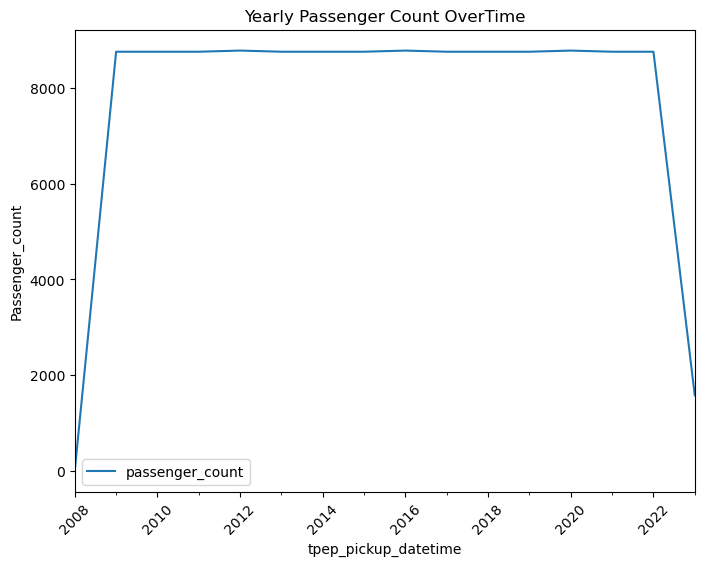

In [10]:
plot_line(df, 'Y', xlabel='tpep_pickup_datetime', ylabel='Passenger_count', title='Yearly Passenger Count OverTime')

<Axes: title={'center': 'Quarterly Passenger Count OverTime'}, xlabel='tpep_pickup_datetime', ylabel='Passenger_count'>

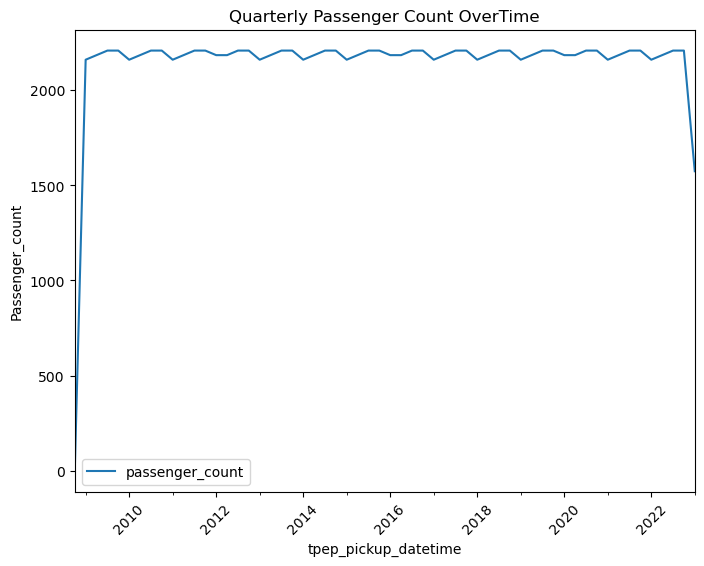

In [11]:
plot_line(df, 'Q', xlabel='tpep_pickup_datetime', ylabel='Passenger_count', title='Quarterly Passenger Count OverTime')

<Axes: title={'center': 'Monthly Passenger Count OverTime'}, xlabel='tpep_pickup_datetime', ylabel='Passenger_count'>

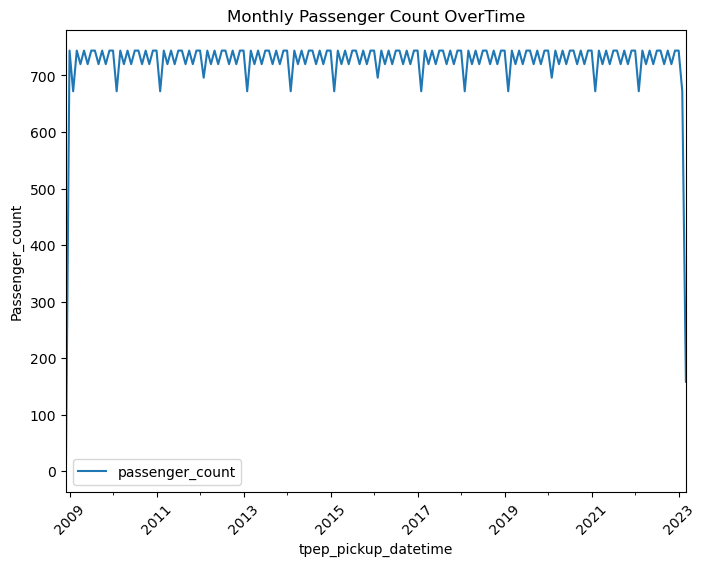

In [12]:
plot_line(df, 'M', xlabel='tpep_pickup_datetime', ylabel='Passenger_count', title='Monthly Passenger Count OverTime')

# Feature Engineering

In [13]:
# convert the date and time when the meter was engaged to seconds
timestamp_s = df.pop('tpep_pickup_datetime').map(pd.Timestamp.timestamp)   

# for subsequent stages of transformation, since taxi data deals with seasonality, it clearly has daily and yearly periodicity.
days_in_yr, hrs_in_day, mins_in_day, secs_in_day = 365.2425, 24, 60, 60  

day = hrs_in_day * mins_in_day * secs_in_day
year = days_in_yr * day

# Apply Fourier transformation 
df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

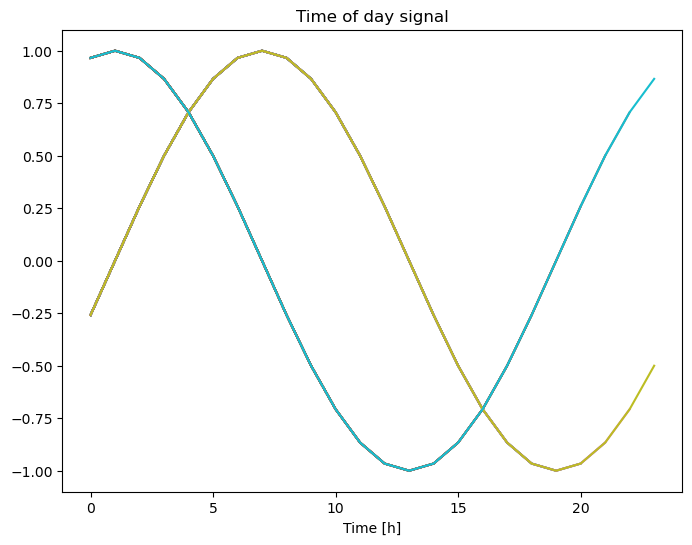

In [14]:
fig, ax = plt.subplots()

for _ in range(25):
    plt.plot(np.array(df['Day sin'])[:_])
    plt.plot(np.array(df['Day cos'])[:_])
    ax.set(title='Time of day signal', xlabel='Time [h]')

# Split Data

In [15]:
# training, validation, and test sets will comprise of (70%, 20%, 10%) of the entire data.
# randomly shuffling the data before splitting is not implemented in this case for two reasons
# - It ensures that slicing the data into windows of consecutive samples is still possible.
# - It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

num_features = df.shape[1]

column_indices = [{idx: colname} for idx, colname in enumerate(df.columns)]

n = len(df)

train_df = df[:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

print(f'Train Set: {train_df.shape},\
        Validation Set: {val_df.shape},\
        Test Set: {test_df.shape},\
        Number of Features: {num_features}'
     )

Train Set: (87000, 5),        Validation Set: (24858, 5),        Test Set: (12429, 5),        Number of Features: 5


# Data Normalization

In [16]:
train_df_labels = train_df.pop('passenger_count')
val_df_labels = val_df.pop('passenger_count')
test_df_labels = test_df.pop('passenger_count') 

# data scaling (subtract the mean and divide by the standard deviation of each feature)
# The mean and standard deviation is computed using the training data so that the models have no access to the values in the validation and test sets.
train_mean, train_std = train_df.mean(), train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

<function __main__.plot_violin(data: pandas.core.frame.DataFrame, t: str = None, xlabel: str = None, ylabel: str = None, title: str = None)>

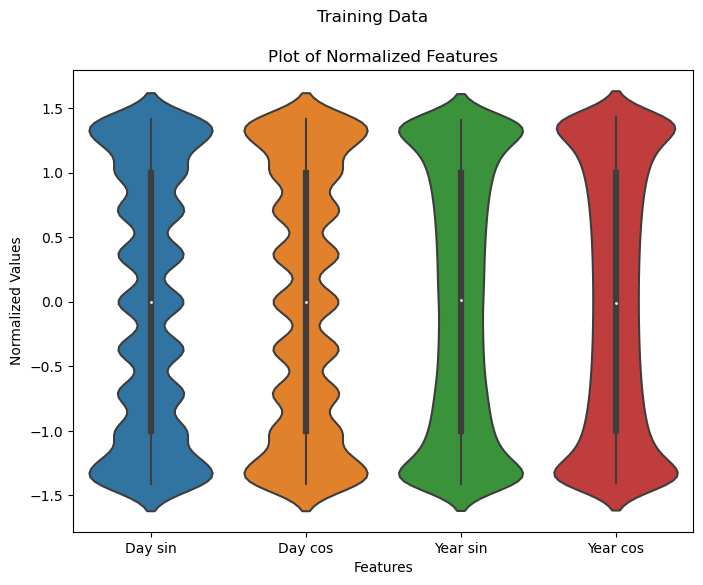

In [17]:
plot_violin(train_df, 'Training Data', 'Features', 'Normalized Values', 'Plot of Normalized Features')

<function __main__.plot_violin(data: pandas.core.frame.DataFrame, t: str = None, xlabel: str = None, ylabel: str = None, title: str = None)>

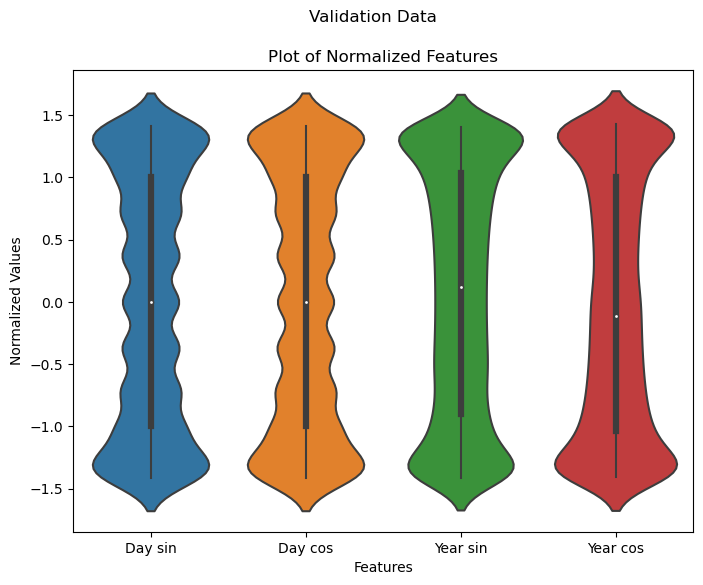

In [18]:
plot_violin(val_df, 'Validation Data', 'Features', 'Normalized Values', 'Plot of Normalized Features')

<function __main__.plot_violin(data: pandas.core.frame.DataFrame, t: str = None, xlabel: str = None, ylabel: str = None, title: str = None)>

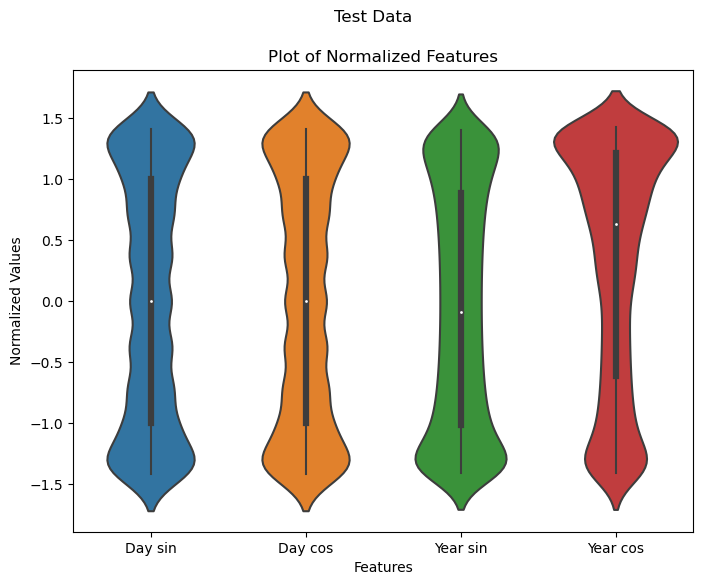

In [19]:
plot_violin(test_df, 'Test Data', 'Features', 'Normalized Values', 'Plot of Normalized Features')

# Data Windowing

In [20]:
def window_dataset(features: pd.DataFrame, targets: pd.DataFrame, sampling_rate: int = 1, **kwargs)-> np.array:
    '''
    Creates a dataset of sliding windows over a timeseries provided as array.

    Args:
    
    features: Numpy array or eager tensor
        containing consecutive data points (timesteps). Axis 0 is expected to be the time dimension.

    targets: Targets corresponding to timesteps in data.

    sampling_rate: Period between successive individual timesteps

    sequence_length: Length of the output sequences (in number of timesteps).

    '''
    dataset =  tf.keras.utils.timeseries_dataset_from_array(
                                                             data=features,
                                                             targets=targets,
                                                             sampling_rate=sampling_rate,
                                                             **kwargs
                                                           )
    
    for samples, targets in dataset:
       print('samples shape:', samples.shape)
       print('targets shape:', targets.shape)
       break
    
    return np.float32(samples), np.float32(targets)

In [21]:
# Observations will go back 5 days (120 hours).
X_train, y_train = window_dataset(train_df, train_df_labels, sequence_length=120, start_index=0)
X_val, y_val = window_dataset(val_df, val_df_labels, sequence_length=120, start_index=0)
X_test, y_test = window_dataset(test_df, test_df_labels, sequence_length=120, start_index=0)

samples shape: (128, 120, 4)
targets shape: (128,)
samples shape: (128, 120, 4)
targets shape: (128,)
samples shape: (128, 120, 4)
targets shape: (128,)


# Data Modelling

In [22]:
model = tf.keras.Sequential(
                            [
                              tf.keras.layers.Dense(128, activation='relu'),
                              tf.keras.layers.Dense(1)
                            ]
                           )

model.compile(
               optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),
               loss='mse',
               metrics=['mae']
             )


history = model.fit(
                     x=X_train,
                     y=y_train,
                     validation_data=(X_val, y_val),
                     batch_size=128,
                     epochs=10,
                     callbacks=tf.keras.callbacks.ModelCheckpoint('nyc_taxi_model', save_best_only=True)
                   )

Epoch 1/10
1/1 [==============================] - ETA: 0s - loss: 0.3069 - mae: 0.1786

INFO:tensorflow:Assets written to: nyc_taxi_model\assets


INFO:tensorflow:Assets written to: nyc_taxi_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.3069 - mae: 0.1786 - val_loss: 0.0081 - val_mae: 0.0646
Epoch 2/10
1/1 [==============================] - ETA: 0s - loss: 0.2923 - mae: 0.1360

INFO:tensorflow:Assets written to: nyc_taxi_model\assets


INFO:tensorflow:Assets written to: nyc_taxi_model\assets


1/1 [==============================] - 1s 591ms/step - loss: 0.2923 - mae: 0.1360 - val_loss: 0.0040 - val_mae: 0.0483
Epoch 3/10
1/1 [==============================] - ETA: 0s - loss: 0.2885 - mae: 0.1073

INFO:tensorflow:Assets written to: nyc_taxi_model\assets


INFO:tensorflow:Assets written to: nyc_taxi_model\assets


1/1 [==============================] - 1s 648ms/step - loss: 0.2885 - mae: 0.1073 - val_loss: 0.0037 - val_mae: 0.0519
Epoch 4/10
1/1 [==============================] - ETA: 0s - loss: 0.2871 - mae: 0.1150

INFO:tensorflow:Assets written to: nyc_taxi_model\assets


INFO:tensorflow:Assets written to: nyc_taxi_model\assets


1/1 [==============================] - 1s 613ms/step - loss: 0.2871 - mae: 0.1150 - val_loss: 0.0030 - val_mae: 0.0476
Epoch 5/10
1/1 [==============================] - 0s 54ms/step - loss: 0.2866 - mae: 0.1081 - val_loss: 0.0030 - val_mae: 0.0486
Epoch 6/10
1/1 [==============================] - ETA: 0s - loss: 0.2864 - mae: 0.1104

INFO:tensorflow:Assets written to: nyc_taxi_model\assets


INFO:tensorflow:Assets written to: nyc_taxi_model\assets


1/1 [==============================] - 1s 607ms/step - loss: 0.2864 - mae: 0.1104 - val_loss: 0.0028 - val_mae: 0.0468
Epoch 7/10
1/1 [==============================] - 0s 48ms/step - loss: 0.2863 - mae: 0.1079 - val_loss: 0.0029 - val_mae: 0.0471
Epoch 8/10
1/1 [==============================] - ETA: 0s - loss: 0.2862 - mae: 0.1090

INFO:tensorflow:Assets written to: nyc_taxi_model\assets


INFO:tensorflow:Assets written to: nyc_taxi_model\assets


1/1 [==============================] - 1s 583ms/step - loss: 0.2862 - mae: 0.1090 - val_loss: 0.0027 - val_mae: 0.0461
Epoch 9/10
1/1 [==============================] - 0s 50ms/step - loss: 0.2862 - mae: 0.1076 - val_loss: 0.0028 - val_mae: 0.0464
Epoch 10/10
1/1 [==============================] - ETA: 0s - loss: 0.2862 - mae: 0.1086

INFO:tensorflow:Assets written to: nyc_taxi_model\assets


INFO:tensorflow:Assets written to: nyc_taxi_model\assets


1/1 [==============================] - 1s 771ms/step - loss: 0.2862 - mae: 0.1086 - val_loss: 0.0027 - val_mae: 0.0455


In [23]:
model_summary_df = pd.DataFrame(history.history)
model_summary_df

,loss,mae,val_loss,val_mae
0,0.306887,0.178572,0.008089,0.064624
1,0.292307,0.135952,0.003972,0.048264
2,0.288503,0.107308,0.003740,0.051879
3,0.287123,0.115030,0.002985,0.047634
4,0.286587,0.108138,0.003025,0.048554
5,0.286372,0.110439,0.002802,0.046798
6,0.286283,0.107875,0.002858,0.047096
7,0.286242,0.109007,0.002740,0.046087
8,0.286220,0.107589,0.002799,0.046395
9,0.286204,0.108591,0.002697,0.045541


# Plot Model History

<Axes: xlabel='Epochs'>

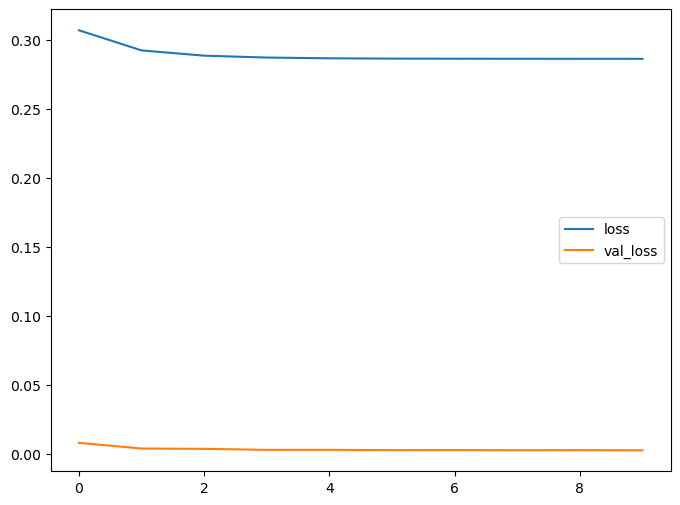

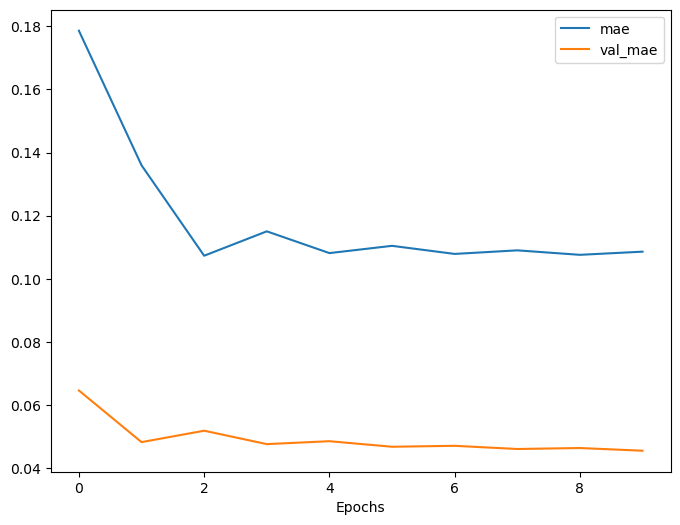

In [24]:
loss_cols = ['loss', 'val_loss']
val_cols = ['mae', 'val_mae']

model_summary_df[loss_cols].plot()
model_summary_df[val_cols].plot(xlabel='Epochs')